In [7]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import os


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# Check the current working directory
current_dir = os.getcwd()

# Define the file paths
hitters_file_path = os.path.join(current_dir, '..', 'data', 'cleaned_matched_hitters.csv')
pitchers_file_path = os.path.join(current_dir, '..', 'data', 'cleaned_matched_pitchers.csv')
# Load the datasets
hitters_df = pd.read_csv(hitters_file_path)
pitchers_df = pd.read_csv(pitchers_file_path)

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Define a function to apply label encoding
def label_encode(df, columns):
    label_encoder = LabelEncoder()
    for col in columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Ensuring it's a string before encoding
    return df

def preprocess_hitters(hitters_df, filter_years=True):
    # Step 1: Filter out rows with Year value of 2023 or 2024 if filter_years is True
    if filter_years:
        hitters_df = hitters_df[~hitters_df['Year'].isin([2023, 2024])]

    # Step 2: Drop irrelevant columns except 'Name'
    drop_cols = ['Avg EV', 'Hard Hit%', 'Max EV', 'ETA', 'Risk', 'Sign Yr', 'Year', 'MLB_Debut', 'Games_Played', 'Years_Before_Debut']
    hitters_df = hitters_df.drop(columns=drop_cols)

    # Step 3: Impute placeholder value for players who have not debuted (Years_Played == 0)
    hitters_df['Years_Played'] = hitters_df['Years_Played'].replace(0, np.nan)
    hitters_df['Years_Played'] = hitters_df['Years_Played'].fillna(-1)

    # Step 4: Calculate WAR_per_Year
    hitters_df['WAR_per_Year'] = hitters_df.apply(lambda row: row['WAR_Sum'] / row['Years_Played'] if row['Years_Played'] > 0 else 0, axis=1)
    hitters_df = hitters_df.drop(columns=['WAR_Sum', 'Years_Played'])

    # Step 5: Handle missing values in Top 100 (fill missing with 999 for unranked players)
    hitters_df['Top 100'] = hitters_df['Top 100'].fillna(999)

    # Step 6: Impute or handle other missing values
    hitters_df['Bat Ctrl'] = hitters_df['Bat Ctrl'].fillna(-1)
    hitters_df['Pitch Sel'] = hitters_df['Pitch Sel'].fillna(-1)
    hitters_df['Fld'] = hitters_df['Fld'].fillna(hitters_df['Fld'].median())
    hitters_df['Bonus'] = hitters_df['Bonus'].fillna(0)
    
    for col in ['Age', 'Ht', 'Wt']:
        hitters_df[col] = hitters_df[col].fillna(hitters_df[col].median())

    # Fill categorical values with 'Unknown' for missing entries
    hitters_df['B'] = hitters_df['B'].fillna('Unknown')
    hitters_df['T'] = hitters_df['T'].fillna('Unknown')
    hitters_df['Sign Mkt'] = hitters_df['Sign Mkt'].fillna('Unknown')

    # Step 7: Label encode categorical columns and save the mapping
    categorical_cols = ['Pos', 'Org', 'B', 'T', 'Sign Mkt']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        hitters_df[col] = le.fit_transform(hitters_df[col].astype(str))
        label_encoders[col] = le

    # Step 8: Scale the features
    scaler = StandardScaler()
    hitters_df_scaled = pd.DataFrame(scaler.fit_transform(hitters_df.drop(columns=['Name'])), columns=hitters_df.drop(columns=['Name']).columns)

    return hitters_df_scaled, scaler, label_encoders

def preprocess_pitchers(pitchers_df, filter_years=True):
    # Step 1: Filter out rows with Year value of 2023 or 2024 if filter_years is True
    if filter_years:
        pitchers_df = pitchers_df[~pitchers_df['Year'].isin([2023, 2024])]

    # Step 2: Drop irrelevant columns except 'Name'
    drop_cols = ['RPM Break', 'RPM FB', 'TJ Date', 'ETA', 'Risk', 'Sign Yr', 'Year', 'MLB_Debut', 'Fld', 'Avg FB Velo', 'Games_Played', 'Years_Before_Debut']
    pitchers_df = pitchers_df.drop(columns=drop_cols)

    # Step 3: Impute placeholder value for players who have not debuted (Years_Played == 0)
    pitchers_df['Years_Played'] = pitchers_df['Years_Played'].replace(0, np.nan)
    pitchers_df['Years_Played'] = pitchers_df['Years_Played'].fillna(-1)

    # Step 4: Calculate WAR_per_Year
    pitchers_df['WAR_per_Year'] = pitchers_df.apply(lambda row: row['WAR_Sum'] / row['Years_Played'] if row['Years_Played'] > 0 else 0, axis=1)
    pitchers_df = pitchers_df.drop(columns=['WAR_Sum', 'Years_Played'])

    # Step 5: Handle missing values in Top 100 (fill missing with 999 for unranked players)
    pitchers_df['Top 100'] = pitchers_df['Top 100'].fillna(999)

    # Step 6: Handle missing values for pitch-specific skills
    pitch_skill_cols = ['SL', 'CB', 'CH', 'Tops']
    for col in pitch_skill_cols:
        pitchers_df[col] = pitchers_df[col].fillna(0)
    
    pitchers_df['CMD'] = pitchers_df['CMD'].fillna(pitchers_df['CMD'].median())
    pitchers_df['Bonus'] = pitchers_df['Bonus'].fillna(0)

    for col in ['Age', 'Ht', 'Wt']:
        pitchers_df[col] = pitchers_df[col].fillna(pitchers_df[col].median())
    
    pitchers_df['B'] = pitchers_df['B'].fillna('Unknown')
    pitchers_df['T'] = pitchers_df['T'].fillna('Unknown')
    pitchers_df['FB Type'] = pitchers_df['FB Type'].fillna('Unknown')
    pitchers_df['Sign Mkt'] = pitchers_df['Sign Mkt'].fillna('Unknown')

    # Step 7: Label encode categorical columns and save the mapping
    categorical_cols = ['Org', 'Pos', 'B', 'T', 'FB Type', 'Sign Mkt']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        pitchers_df[col] = le.fit_transform(pitchers_df[col].astype(str))
        label_encoders[col] = le

    # Step 8: Scale the features
    scaler = StandardScaler()
    pitchers_df_scaled = pd.DataFrame(scaler.fit_transform(pitchers_df.drop(columns=['Name'])), columns=pitchers_df.drop(columns=['Name']).columns)

    return pitchers_df_scaled, scaler, label_encoders
# Apply preprocessing functions
hitters_df, scaler_hitters, label_encoders_hitters = preprocess_hitters(hitters_df)
pitchers_df, scaler_pitchers, label_encoders_pitchers = preprocess_pitchers(pitchers_df)

# Extract the target variable and features
# For hitters
y_train_hit = hitters_df['WAR_per_Year']
X_train_hit = hitters_df.drop(columns=['WAR_per_Year'])

# For pitchers
y_train_pitch = pitchers_df['WAR_per_Year']
X_train_pitch = pitchers_df.drop(columns=['WAR_per_Year'])

# Split data into training and validation sets
X_train_hit, X_val_hit, y_train_hit, y_val_hit = train_test_split(X_train_hit, y_train_hit, test_size=0.2, random_state=42)
X_train_pitch, X_val_pitch, y_train_pitch, y_val_pitch = train_test_split(X_train_pitch, y_train_pitch, test_size=0.2, random_state=42)

# Ensure all columns are numeric
X_train_hit = X_train_hit.apply(pd.to_numeric, errors='ignore')
X_val_hit = X_val_hit.apply(pd.to_numeric, errors='ignore')
X_train_pitch = X_train_pitch.apply(pd.to_numeric, errors='ignore')
X_val_pitch = X_val_pitch.apply(pd.to_numeric, errors='ignore')

# Fill NaN values with the median of each column
X_train_hit = X_train_hit.fillna(X_train_hit.median())
X_val_hit = X_val_hit.fillna(X_val_hit.median())
X_train_pitch = X_train_pitch.fillna(X_train_pitch.median())
X_val_pitch = X_val_pitch.fillna(X_val_pitch.median())

#print column names for hitters and pitchers
print(X_train_hit.columns)
print(X_train_pitch.columns)

Index(['Bat Ctrl', 'Fld', 'Game', 'Hit', 'Org', 'Pitch Sel', 'Pos', 'Raw',
       'Spd', 'Age', 'B', 'Bonus', 'FV', 'Ht', 'Org Rk', 'Sign Mkt', 'T',
       'Top 100', 'Wt'],
      dtype='object')
Index(['CB', 'CH', 'CMD', 'FB', 'FB Type', 'Org', 'Pos', 'SL', 'Tops', 'Age',
       'B', 'Bonus', 'FV', 'Ht', 'Org Rk', 'Sign Mkt', 'T', 'Top 100', 'Wt'],
      dtype='object')


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WARPerYearPredictor(nn.Module):
    def __init__(self, input_dim):
        super(WARPerYearPredictor, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
        
        # Define dropout layers for regularization
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Apply the first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply the second fully connected layer and ReLU activation
        x = F.relu(self.fc2(x))
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply the third fully connected layer and ReLU activation
        x = F.relu(self.fc3(x))
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply the fourth fully connected layer and ReLU activation
        x = F.relu(self.fc4(x))
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply the fifth fully connected layer and ReLU activation
        x = F.relu(self.fc5(x))
        
        # Apply the final fully connected layer
        x = self.fc6(x)
        
        return x

In [11]:
import torch.optim as optim

# Define the input dimension based on the number of features in the dataset
input_dim_hitters = X_train_hit.shape[1]
input_dim_pitchers = X_train_pitch.shape[1]

# Instantiate the model for hitters and pitchers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hitters = WARPerYearPredictor(input_dim=input_dim_hitters).to(device)
model_pitchers = WARPerYearPredictor(input_dim=input_dim_pitchers).to(device)

# Define hyperparameters
learning_rate = 0.001
num_epochs = 150
batch_size = 32

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_hitters = optim.Adam(model_hitters.parameters(), lr=learning_rate)
optimizer_pitchers = optim.Adam(model_pitchers.parameters(), lr=learning_rate)


In [12]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, num_epochs, batch_size, device, writer, model_name):
    # Set up DataLoader for batching
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)), batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_train_loss += loss.item()
            writer.add_scalar(f'{model_name}/Train Batch Loss', loss.item(), epoch * len(train_loader) + batch_idx)

        # Calculate average train loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        writer.add_scalar(f'{model_name}/Train Loss', avg_train_loss, epoch)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item()
                writer.add_scalar(f'{model_name}/Val Batch Loss', loss.item(), epoch * len(val_loader) + batch_idx)

        # Calculate average validation loss for the epoch
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        writer.add_scalar(f'{model_name}/Val Loss', avg_val_loss, epoch)

        # Print loss every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

# Initialize TensorBoard writer
writer = SummaryWriter()

# Train the model for hitters
train_losses_hitters, val_losses_hitters = train_model(
    model=model_hitters,
    optimizer=optimizer_hitters,
    criterion=criterion,
    X_train=X_train_hit,
    y_train=y_train_hit,
    X_val=X_val_hit,
    y_val=y_val_hit,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    writer=writer,
    model_name='Hitters'
)

# Train the model for pitchers
train_losses_pitchers, val_losses_pitchers = train_model(
    model=model_pitchers,
    optimizer=optimizer_pitchers,
    criterion=criterion,
    X_train=X_train_pitch,
    y_train=y_train_pitch,
    X_val=X_val_pitch,
    y_val=y_val_pitch,
    num_epochs=num_epochs,
    batch_size=batch_size,
    device=device,
    writer=writer,
    model_name='Pitchers'
)


Epoch [5/150], Train Loss: 0.8775, Val Loss: 0.7426
Epoch [10/150], Train Loss: 0.8242, Val Loss: 0.7233
Epoch [15/150], Train Loss: 0.7803, Val Loss: 0.7158
Epoch [20/150], Train Loss: 0.7587, Val Loss: 0.6799
Epoch [25/150], Train Loss: 0.6915, Val Loss: 0.6782
Epoch [30/150], Train Loss: 0.6798, Val Loss: 0.6360
Epoch [35/150], Train Loss: 0.6820, Val Loss: 0.6471
Epoch [40/150], Train Loss: 0.6392, Val Loss: 0.6307
Epoch [45/150], Train Loss: 0.6166, Val Loss: 0.6415
Epoch [50/150], Train Loss: 0.5775, Val Loss: 0.6294
Epoch [55/150], Train Loss: 0.5526, Val Loss: 0.6082
Epoch [60/150], Train Loss: 0.5635, Val Loss: 0.5959
Epoch [65/150], Train Loss: 0.5591, Val Loss: 0.5946
Epoch [70/150], Train Loss: 0.5535, Val Loss: 0.6121
Epoch [75/150], Train Loss: 0.4910, Val Loss: 0.5896
Epoch [80/150], Train Loss: 0.4697, Val Loss: 0.5919
Epoch [85/150], Train Loss: 0.5147, Val Loss: 0.5609
Epoch [90/150], Train Loss: 0.4992, Val Loss: 0.5543
Epoch [95/150], Train Loss: 0.4671, Val Loss: 0

In [16]:
# Reload the datasets
new_hitters_df = pd.read_csv(hitters_file_path)
new_pitchers_df = pd.read_csv(pitchers_file_path)

# Filter the data for rows where the "Year" is 2024
hitters_2024_df = new_hitters_df[new_hitters_df['Year'] == 2024]
pitchers_2024_df = new_pitchers_df[new_pitchers_df['Year'] == 2024]

# Extract the Name column
hitters_names_2024 = hitters_2024_df['Name']
pitchers_names_2024 = pitchers_2024_df['Name']

# Preprocess the data without filtering out the year 2024
hitters_2024_df, scaler_hitters_2024, label_encoders_hitters = preprocess_hitters(hitters_2024_df, filter_years=False)
pitchers_2024_df, scaler_pitchers_2024, label_encoders_pitchers = preprocess_pitchers(pitchers_2024_df, filter_years=False)

# Ensure all columns are numeric
hitters_2024_df = hitters_2024_df.apply(pd.to_numeric, errors='ignore')
pitchers_2024_df = pitchers_2024_df.apply(pd.to_numeric, errors='ignore')

# Extract features (drop the target variable if it exists)
X_hitters_2024 = hitters_2024_df.drop(columns=['WAR_per_Year'], errors='ignore')
X_pitchers_2024 = pitchers_2024_df.drop(columns=['WAR_per_Year'], errors='ignore')

# Convert to tensors
X_hitters_2024_tensor = torch.tensor(X_hitters_2024.values, dtype=torch.float32).to(device)
X_pitchers_2024_tensor = torch.tensor(X_pitchers_2024.values, dtype=torch.float32).to(device)

# Set the models to evaluation mode
model_hitters.eval()
model_pitchers.eval()

# Initialize arrays to store predictions
predictions_hitters_2024_all = []
predictions_pitchers_2024_all = []

# Run the model 100 times and collect predictions
for _ in range(1):
    with torch.no_grad():
        predictions_hitters_2024 = model_hitters(X_hitters_2024_tensor).cpu().numpy()
        predictions_pitchers_2024 = model_pitchers(X_pitchers_2024_tensor).cpu().numpy()
        predictions_hitters_2024_all.append(predictions_hitters_2024)
        predictions_pitchers_2024_all.append(predictions_pitchers_2024)

# Average the predictions
predictions_hitters_2024_avg = np.mean(predictions_hitters_2024_all, axis=0)
predictions_pitchers_2024_avg = np.mean(predictions_pitchers_2024_all, axis=0)

# Extrapolate the predicted WAR per year to 6 years
predicted_war_6_years_hitters = predictions_hitters_2024_avg * 6
predicted_war_6_years_pitchers = predictions_pitchers_2024_avg * 6

# Unscale the data
hitters_2024_unscaled = pd.DataFrame(scaler_hitters_2024.inverse_transform(hitters_2024_df), columns=hitters_2024_df.columns)
pitchers_2024_unscaled = pd.DataFrame(scaler_pitchers_2024.inverse_transform(pitchers_2024_df), columns=pitchers_2024_df.columns)

# Decode the 'Org' column
hitters_2024_unscaled['Org'] = label_encoders_hitters['Org'].inverse_transform(hitters_2024_unscaled['Org'].astype(int))
pitchers_2024_unscaled['Org'] = label_encoders_pitchers['Org'].inverse_transform(pitchers_2024_unscaled['Org'].astype(int))

# Create DataFrames with the Name, Top 100, and extrapolated WAR
hitters_2024_results = pd.DataFrame({
    'Name': hitters_names_2024.values[:len(predicted_war_6_years_hitters)],
    'Predicted_WAR_6_Years': predicted_war_6_years_hitters.flatten(),
    'Top 100': hitters_2024_unscaled['Top 100'].values[:len(predicted_war_6_years_hitters)],
    'Org': hitters_2024_unscaled['Org'].values[:len(predicted_war_6_years_hitters)],
    'Org Rk': hitters_2024_unscaled['Org Rk'].values[:len(predicted_war_6_years_hitters)]
})

pitchers_2024_results = pd.DataFrame({
    'Name': pitchers_names_2024.values[:len(predicted_war_6_years_pitchers)],
    'Predicted_WAR_6_Years': predicted_war_6_years_pitchers.flatten(),
    'Top 100': pitchers_2024_unscaled['Top 100'].values[:len(predicted_war_6_years_pitchers)],
    'Org': pitchers_2024_unscaled['Org'].values[:len(predicted_war_6_years_pitchers)],
    'Org Rk': pitchers_2024_unscaled['Org Rk'].values[:len(predicted_war_6_years_pitchers)]
})

# Set 'Top 100' to NaN where the value is 999
hitters_2024_results.loc[hitters_2024_results['Top 100'] == 999, 'Top 100'] = np.nan
pitchers_2024_results.loc[pitchers_2024_results['Top 100'] == 999, 'Top 100'] = np.nan

# Sort by predicted WAR
hitters_2024_results = hitters_2024_results.sort_values(by='Predicted_WAR_6_Years', ascending=False)
pitchers_2024_results = pitchers_2024_results.sort_values(by='Predicted_WAR_6_Years', ascending=False)

# Save the results to CSV files with a different encoder to maintain Latin players' names
hitters_2024_results.to_csv('../data/generated/hitters_2024_predicted_war_6_years.csv', index=False, encoding='utf-8-sig')
pitchers_2024_results.to_csv('../data/generated/pitchers_2024_predicted_war_6_years.csv', index=False, encoding='utf-8-sig')

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate permutation feature importance
def permutation_feature_importance(model, X_val, y_val, device, n_repeats=5):
    baseline_preds = model(torch.tensor(X_val.values, dtype=torch.float32).to(device)).cpu().detach().numpy()
    baseline_error = mean_squared_error(y_val, baseline_preds)
    
    feature_importances = np.zeros(X_val.shape[1])
    
    for col in range(X_val.shape[1]):
        errors = []
        for _ in range(n_repeats):
            X_val_permuted = X_val.copy()
            X_val_permuted.iloc[:, col] = np.random.permutation(X_val_permuted.iloc[:, col])
            permuted_preds = model(torch.tensor(X_val_permuted.values, dtype=torch.float32).to(device)).cpu().detach().numpy()
            permuted_error = mean_squared_error(y_val, permuted_preds)
            errors.append(permuted_error)
        feature_importances[col] = np.mean(errors) - baseline_error
    
    return feature_importances

# Calculate feature importance for hitters
hitters_feature_importances = permutation_feature_importance(model_hitters, X_val_hit, y_val_hit, device)

# Calculate feature importance for pitchers
pitchers_feature_importances = permutation_feature_importance(model_pitchers, X_val_pitch, y_val_pitch, device)

# Create DataFrames for feature importances
hitters_feature_importance_df = pd.DataFrame({
    'Feature': X_val_hit.columns,
    'Importance': hitters_feature_importances
}).sort_values(by='Importance', ascending=False)

pitchers_feature_importance_df = pd.DataFrame({
    'Feature': X_val_pitch.columns,
    'Importance': pitchers_feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features for hitters and pitchers
print("Top 10 most important features for hitters:")
print(hitters_feature_importance_df.head(10))

print("\nTop 10 most important features for pitchers:")
print(pitchers_feature_importance_df.head(10))

Top 10 most important features for hitters:
     Feature  Importance
12        FV    0.169386
1        Fld    0.155301
17   Top 100    0.144138
3        Hit    0.137716
6        Pos    0.125226
10         B    0.109996
18        Wt    0.107005
13        Ht    0.089975
4        Org    0.086559
15  Sign Mkt    0.081798

Top 10 most important features for pitchers:
     Feature  Importance
12        FV    0.110928
13        Ht    0.106971
10         B    0.071798
11     Bonus    0.069307
2        CMD    0.067861
16         T    0.057798
14    Org Rk    0.048953
15  Sign Mkt    0.048025
7         SL    0.046539
1         CH    0.043718


C:\Users\User\AppData\Local\Temp\ipykernel_148\433625857.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=hitters_feature_importance_df.head(10), palette='viridis')


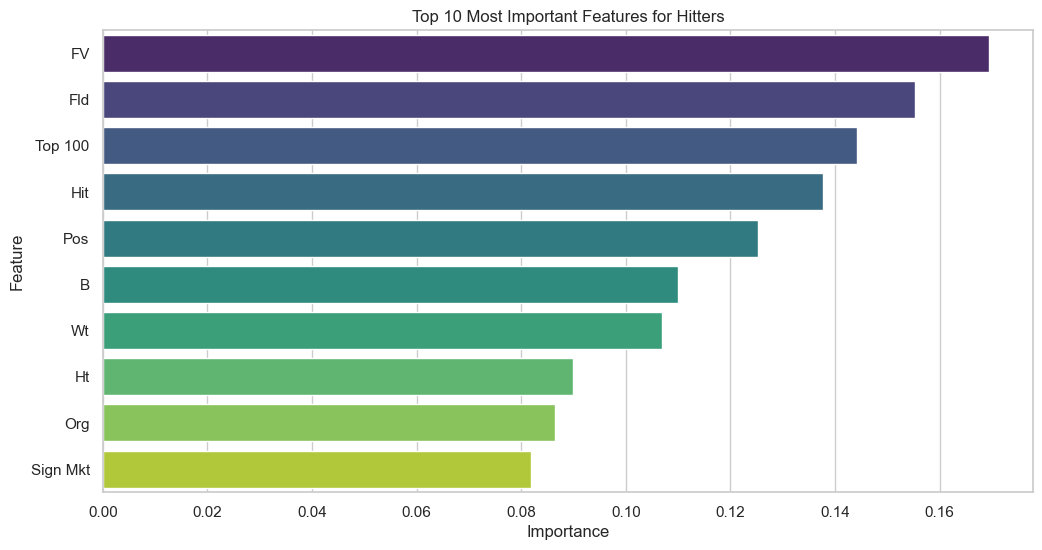

C:\Users\User\AppData\Local\Temp\ipykernel_148\433625857.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=pitchers_feature_importance_df.head(10), palette='viridis')


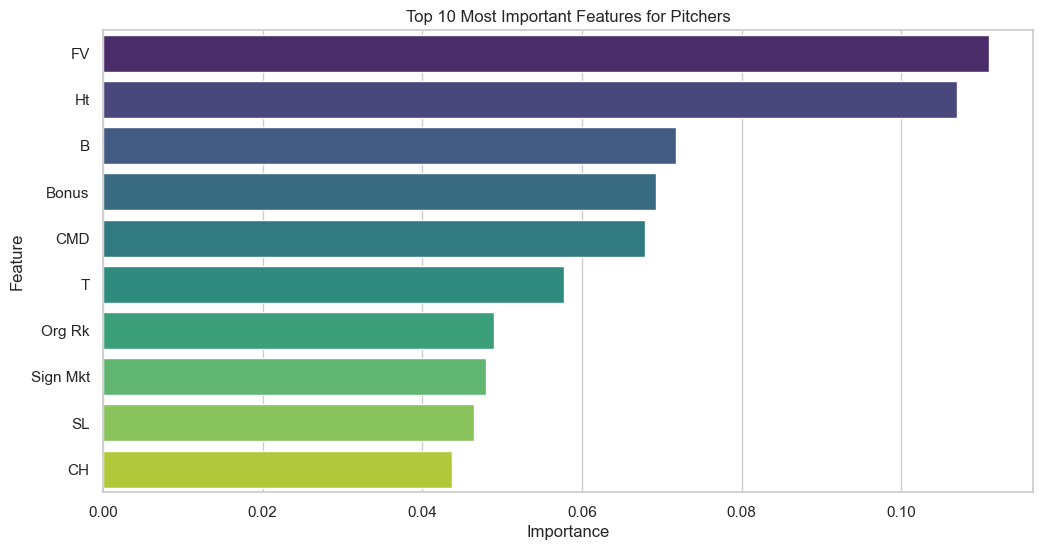

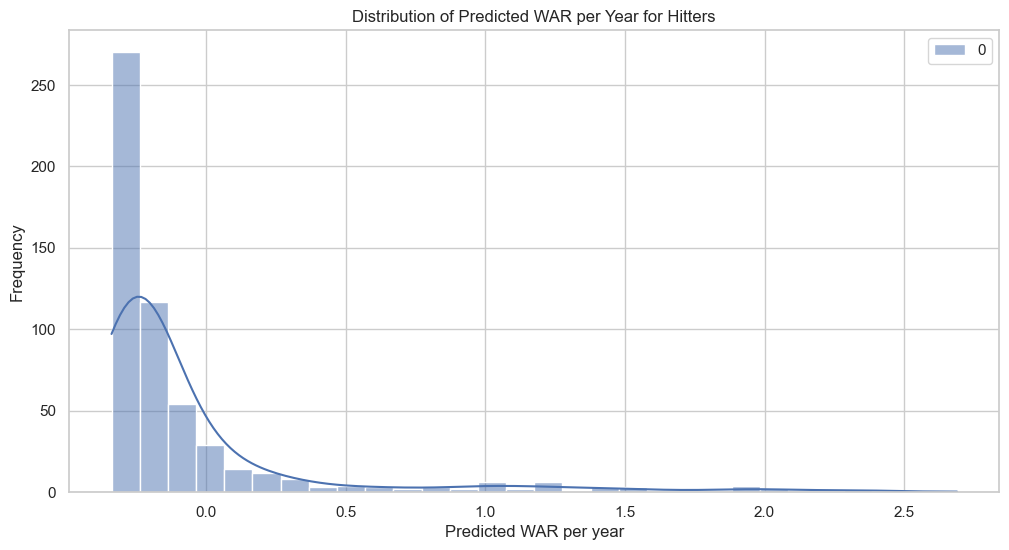

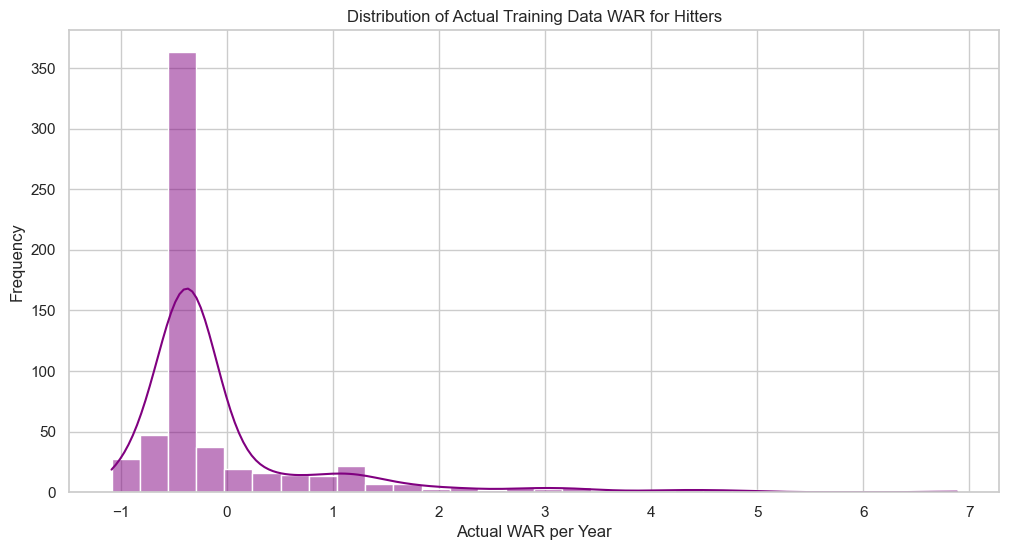

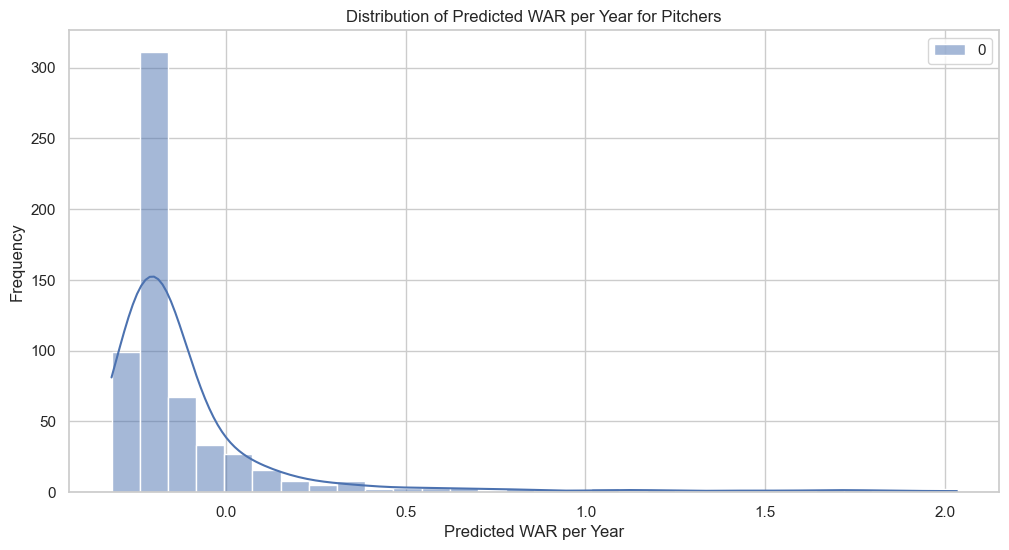

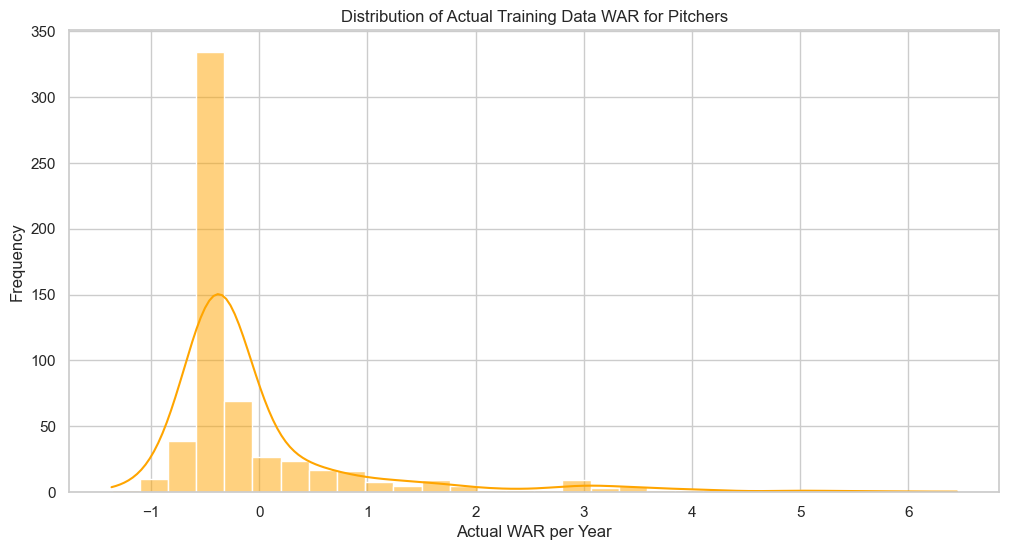

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Plot the top 10 most important features for hitters
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=hitters_feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Hitters')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('../results/top_10_hitters_features.png')
plt.show()

# Plot the top 10 most important features for pitchers
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=pitchers_feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Pitchers')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('../results/top_10_pitchers_features.png')
plt.show()

# Additional visualizations
# Distribution of predicted WAR for hitters per year
plt.figure(figsize=(12, 6))
sns.histplot(predictions_hitters_2024_avg, bins=30, kde=True, color='blue')
plt.title('Distribution of Predicted WAR per Year for Hitters')
plt.xlabel('Predicted WAR per year')
plt.ylabel('Frequency')
plt.savefig('../results/pred_hit_war_distribution.png')
plt.show()

# Distribution of actual training data WAR for hitters
plt.figure(figsize=(12, 6))
sns.histplot(y_val_hit, bins=30, kde=True, color='purple')
plt.title('Distribution of Actual Training Data WAR for Hitters')
plt.xlabel('Actual WAR per Year')
plt.ylabel('Frequency')
plt.savefig('../results/train_hit_war_distribution.png')
plt.show()

# Distribution of predicted WAR for pitchers
plt.figure(figsize=(12, 6))
sns.histplot(predictions_pitchers_2024_avg, bins=30, kde=True, color='green')
plt.title('Distribution of Predicted WAR per Year for Pitchers')
plt.xlabel('Predicted WAR per Year')
plt.ylabel('Frequency')
plt.savefig('../results/pred_pit_war_distribution.png')
plt.show()

# Distribution of actual training data WAR for pitchers
plt.figure(figsize=(12, 6))
sns.histplot(y_val_pitch, bins=30, kde=True, color='orange')
plt.title('Distribution of Actual Training Data WAR for Pitchers')
plt.xlabel('Actual WAR per Year')
plt.ylabel('Frequency')
plt.savefig('../results/train_pit_war_distribution.png')
plt.show()